## Imports

In [ ]:
! pip install --upgrade -q pyarrow pylance kaggle diffusers[training]

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from dataclasses import dataclass

import lance
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

from diffusers import DDPMPipeline
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

## Hyperparameters and Dataset

Below, we define a dataclass consisting of the hyperparameters for our model training.

We also take a look at the dataset by loading and printing the first 4 images from the dataset.

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 4
    eval_batch_size = 4
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub
    seed = 0

config = TrainingConfig()

In [ ]:
def load_image(ds, idx):
    # Utility function to load an image at an index and convert it from bytes format to img format
    raw_img = ds.take([idx], columns=['image']).to_pydict()
    raw_img = np.frombuffer(b''.join(raw_img['image']), dtype=np.uint8)
    img = cv2.imdecode(raw_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

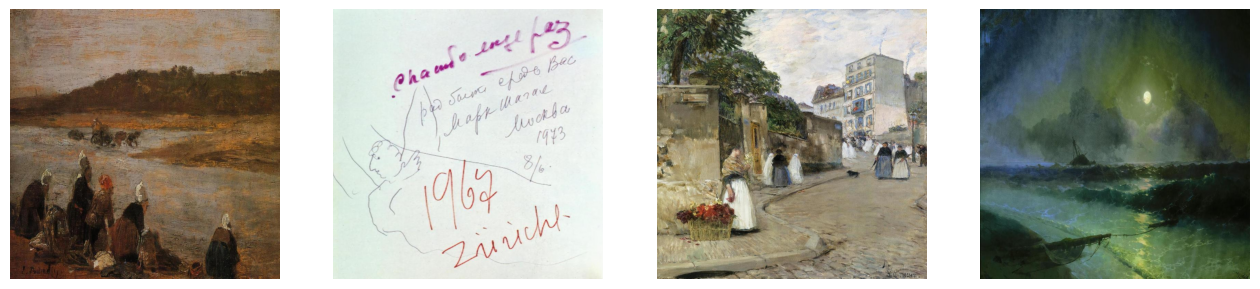

In [ ]:
# Load and plot 4 images from the lance dataset
ds = lance.dataset("huggan_wikiart.lance")
idxs = [x for x in range(4)]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in idxs:
    image = load_image(ds, i)
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
# Some basic transformation to be used during training
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
class WikiartDataset(Dataset):
    """Custom Dataset to load, pre-process and transform the images"""
    def __init__(self, lance_path, transforms):
        self.ds = lance.dataset(lance_path)
        self.transforms = transforms

    def __len__(self):
        return self.ds.count_rows()

    def __getitem__(self, idx):
        # Load the image
        img = load_image(self.ds, idx)

        if self.transforms:
            img = self.transforms(img)

        return img

train_dataset = WikiartDataset("huggan_wikiart.lance", transforms=preprocess)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.train_batch_size,
    shuffle=False
)

## Model and Other definitions

For this simple example, we are using a UNet2D model and defining a noise scheduler (for adding noise to the clean images), an optimizer and a learning rate scheduler.

In [ ]:
# Define a UNet2DModel
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Utility functions

We also define some utility functions to evaulate the images at certain epochs and save them for later.

In [ ]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

## Training

Finally, we train the model. Training is pretty much the same as you would expect in a normal model since we made our dataset I/O similar with other popular dataset formats.

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    model.train()
    model = model.to('cuda')

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        for step, img_batch in enumerate(train_dataloader):
            clean_images = img_batch.to('cuda')
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            evaluate(config, epoch, pipeline)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            pipeline.save_pretrained(config.output_dir)

In [ ]:
# Train the model
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)